In [1]:
cd ../..

c:\Users\Josu\Documents\Workspace\Human-Benchmark\src\server\model


In [8]:
import glob

import chess
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy import stats
from scripts.utils import bitboard, tanh
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
XX, yy = [], []
for file in glob.glob("data/npz/*.npz"):
    with np.load(file) as f:
        XX.append(f["X"]), yy.append(f["y"])
X, y = np.concatenate(XX), np.concatenate(yy)

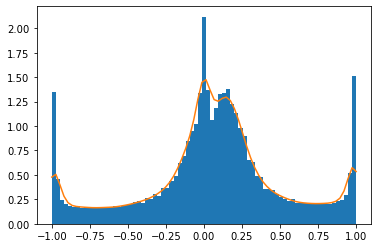

In [6]:
_, x, _ = plt.hist(y, bins=75, density=True)  
ax = plt.plot(x,  stats.gaussian_kde(y)(x))

In [9]:
# == BODY == #
FILTERS = 128
inputs = layers.Input(shape=(8, 8, 6))
y = layers.Conv2D(FILTERS, (3, 3), padding="same")(inputs)

# == RESIDUAL_TOWER == #
BLOCKS = 10
for _ in range(BLOCKS):
    x = layers.Conv2D(FILTERS, (3, 3), padding="same")(y)
    x = layers.Conv2D(FILTERS, (3, 3), padding="same")(x)

    # == SQUEEZE_AND_EXITATION == #
    SE_CHANNELS = 32
    x = layers.GlobalAveragePooling2D()(y)
    x = layers.Dense(SE_CHANNELS, activation="relu")(x)
    x = layers.Reshape((2, FILTERS))(x)
    x = layers.Dense(FILTERS)(x)
    W, B = tf.unstack(x, axis=1)
    Z = layers.Activation("sigmoid")(W)
    # Use lambda here
    x = layers.Add()((layers.Multiply()((Z, y)), B))

    x = layers.Add()((x, y))
    x = layers.ReLU()(x)

# == POLICY_HEAD == #
POLICY_CONV_SIZE = 32
ph = layers.Conv2D(POLICY_CONV_SIZE, (3, 3), padding="same")(x)
ph = layers.Flatten()(ph)
ph = layers.Dense(1858)(ph)

# == VALUE_HEAD == #
vh = layers.Conv2D(32, (3, 3), padding="same")(x)
vh = layers.Conv2D(128, (3, 3), activation="relu")(vh)
vh = layers.Flatten()(vh)
vh = layers.Dense(1, activation="tanh")(vh)

In [10]:
model = keras.Model(inputs=inputs, outputs=(ph, vh))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 8, 8, 128)    7040        input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_10 (Gl (None, 128)          0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 32)           4128        global_average_pooling2d_10[0][0]
______________________________________________________________________________________________

In [22]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=["accuracy"]
)

In [23]:
_ = model.fit(
    x=X,
    y=y,
    batch_size=32,
    epochs=5,
    validation_split=0.2
)

Epoch 1/5
9819/9819 [==============================] - 140s 14ms/step - loss: 0.7675 - accuracy: 0.3131 - val_loss: 0.7196 - val_accuracy: 0.3171
Epoch 2/5
9819/9819 [==============================] - 134s 14ms/step - loss: 0.7208 - accuracy: 0.3615 - val_loss: 0.7134 - val_accuracy: 0.3398
Epoch 3/5
9819/9819 [==============================] - 137s 14ms/step - loss: 0.7106 - accuracy: 0.3672 - val_loss: 0.6902 - val_accuracy: 0.3701
Epoch 4/5
9819/9819 [==============================] - 134s 14ms/step - loss: 0.7039 - accuracy: 0.3702 - val_loss: 0.6881 - val_accuracy: 0.3577
Epoch 5/5
9819/9819 [==============================] - 143s 15ms/step - loss: 0.6989 - accuracy: 0.3731 - val_loss: 0.6811 - val_accuracy: 0.3581


In [46]:
model.predict(
    np.array([
        bitboard(chess.Board("1nbqkbnr/rppppppp/8/p7/3PP3/5N2/PPP2PPP/RNBQKB1R b KQk - 0 1"))
    ])
)

array([[0.9999661]], dtype=float32)